In [2]:
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
from lstm import LSTM
from ddpm import DDPM, ContextUnet
from grayscott import GrayScott
from training import train_lstm, train_ddpm
from analyzer import Analyzer
from constants import *

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

def create_shapes_dataset(samples=100, size=32):
    data = []
    for _ in range(samples):
        img = np.zeros((size, size))
        
        # Random Square
        x = np.random.randint(5, size-10)
        y = np.random.randint(5, size-10)
        w = np.random.randint(5, 10)
        img[x:x+w, y:y+w] = 1.0
        
        data.append(img)
        
    # Shape: [Batch, Channels=1, Height, Width]
    return torch.FloatTensor(np.array(data)).unsqueeze(1)

In [5]:
samples = create_sine_dataset(100,500)
samples.size()

torch.Size([100, 500, 1])

In [6]:
samples_shape = create_shapes_dataset(100,32)
samples_shape.size()

torch.Size([100, 1, 32, 32])

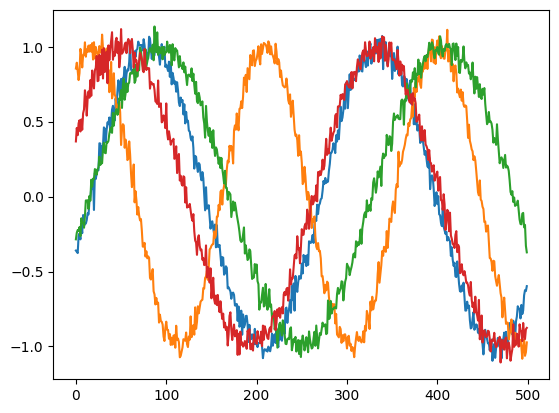

In [7]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
n_samples = 1000
seq_len = 500
n_epochs = 200

In [10]:
lstm_data = create_sine_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = lstm_data.to(device)

lstm_model = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM ---
Epoch 0: Loss 0.60384
Epoch 10: Loss 0.41955
Epoch 20: Loss 0.29340
Epoch 30: Loss 0.21242
Epoch 40: Loss 0.15656
Epoch 50: Loss 0.11534
Epoch 60: Loss 0.08598
Epoch 70: Loss 0.06605
Epoch 80: Loss 0.05280
Epoch 90: Loss 0.04417
Epoch 100: Loss 0.03868
Epoch 110: Loss 0.03520
Epoch 120: Loss 0.03300
Epoch 130: Loss 0.03159
Epoch 140: Loss 0.03065
Epoch 150: Loss 0.03000
Epoch 160: Loss 0.02953
Epoch 170: Loss 0.02917
Epoch 180: Loss 0.02888
Epoch 190: Loss 0.02863
Epoch 200: Loss 0.02842
Epoch 210: Loss 0.02823
Epoch 220: Loss 0.02806
Epoch 230: Loss 0.02791
Epoch 240: Loss 0.02777
Epoch 250: Loss 0.02764
Epoch 260: Loss 0.02752
Epoch 270: Loss 0.02740
Epoch 280: Loss 0.02729
Epoch 290: Loss 0.02719
Epoch 300: Loss 0.02710
Epoch 310: Loss 0.02700
Epoch 320: Loss 0.02692
Epoch 330: Loss 0.02683
Epoch 340: Loss 0.02675
Epoch 350: Loss 0.02667
Epoch 360: Loss 0.02660
Epoch 370: Loss 0.02652
Epoch 380: Loss 0.02645
Epoch 390: Loss 0.02638
Epoch 400: Loss 0.02631
Epoch

Text(0.5, 0, 'epoch')

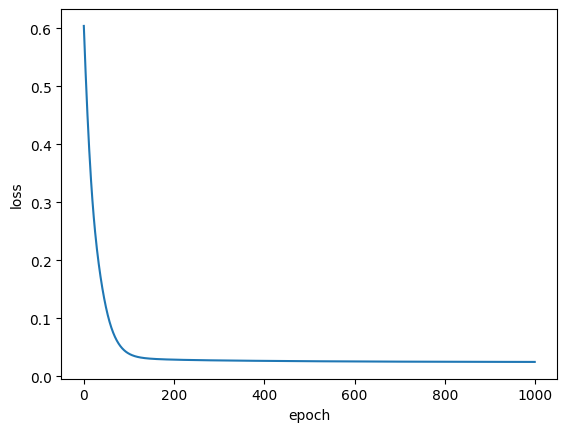

In [ ]:
loss_lstm = train_lstm(lstm_model, lstm_data, epochs=n_epochs, device=device)

plt.plot(loss_lstm)
plt.ylabel("loss")
plt.xlabel("epoch")

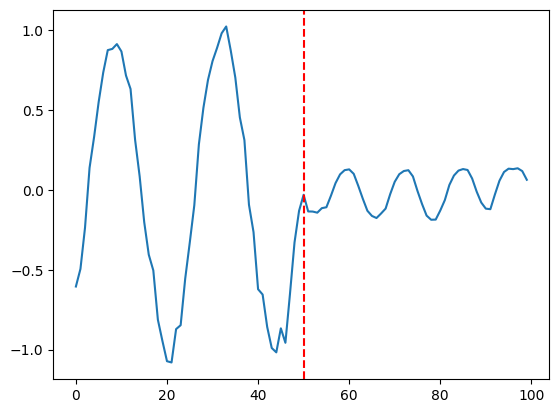

In [ ]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]

future_steps = 50
generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

plt.plot(torch.cat((seed_sample, generated)))
plt.axvline(x=seq_len, color='red', linestyle='--')

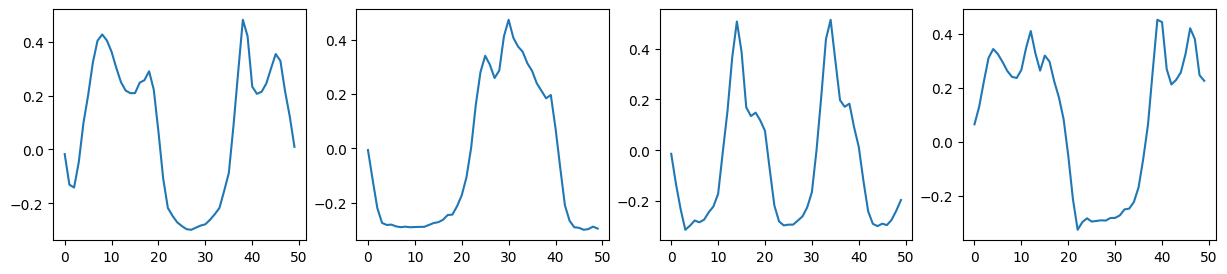

In [ ]:
lstm_out, history = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_out[rand_index,:,0].to("cpu").detach().numpy())
plt.show()

In [62]:
forget = [[t[0, d].item() for t in history["forget"]] for d in range(16)]
len(forget[0])

50

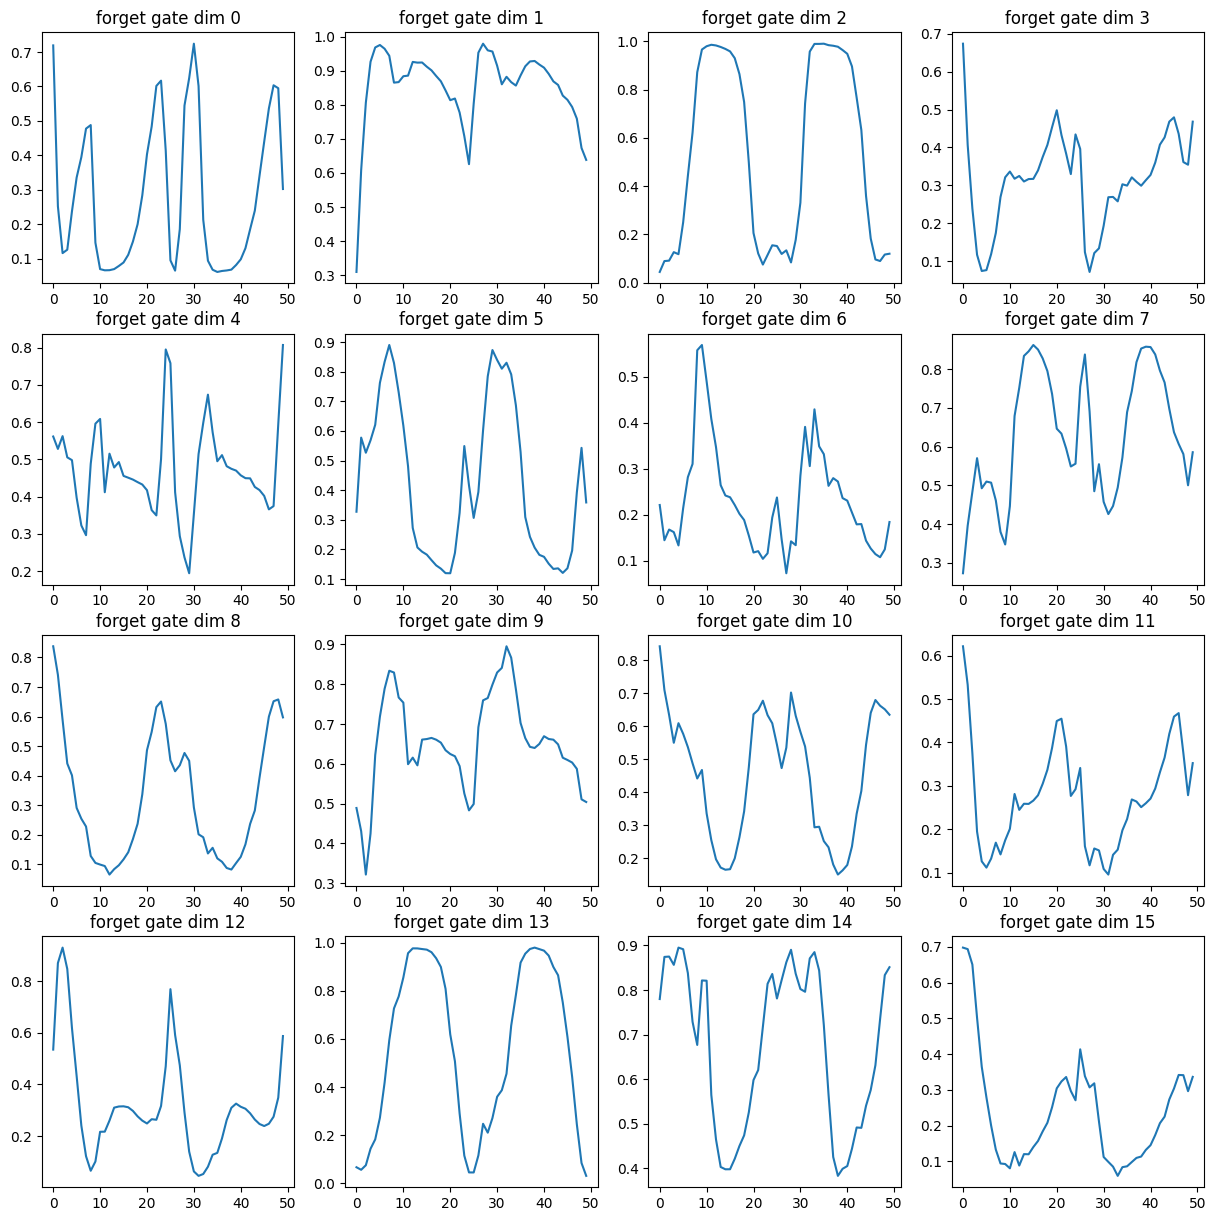

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,n_samples)
forget_coef = [[t[rand_sample, d].item() for t in history["forget"]] for d in range(16)]
for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget[4*i+j])
        ax[i,j].set_title(f"forget gate dim {4*i+j}")
plt.show()

In [ ]:
n_epoch = 20
batch_size = 128
n_T = 400

In [ ]:
# --- Data Loading ---
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
dataset = datasets.MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# --- Setup Schedules (The "Inhibitor" Physics) ---
beta_1 = 1e-4
beta_T = 0.02
betas = torch.linspace(beta_1, beta_T, n_T + 1).to(device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

# Pre-calculate standard DDPM constants to save compute
ddpm_schedules = {
    "sqrtab": torch.sqrt(alphas_bar),
    "sqrtmab": torch.sqrt(1 - alphas_bar),
    "oneover_sqrta": 1 / torch.sqrt(alphas),
    "mab_over_sqrtmab": (1 - alphas) / torch.sqrt(1 - alphas_bar),
    "sqrt_beta_t": torch.sqrt(betas),
}

unet_model = ContextUnet(in_channels=1, n_feat=64).to(device)
ddpm_model = DDPM(unet_model, ddpm_schedules, n_T, device)

In [ ]:
loss_ddpm = train_ddpm(ddpm_model, dataloader, epochs=n_epochs, device=device)

plt.plot(loss_ddpm)
plt.ylabel("loss")
plt.xlabel("epoch")

In [ ]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs = GrayScott(F=F_DEFAULT, k=k_DEFAULT, D_u=Du_DEFAULT, D_v=Dv_DEFAULT, x0=x0, x1=x1, N=N)
_, V_final, V_history, _, _ = gs.forward(0, 5000, frame=False, data=False)
gs_final = V_final[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm = LSTM().to(device)
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].to("cpy").detach().numpy()
lstm_history = lstm_output[0, :, :].to("cpu").detach().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
unet_model = ContextUnet(in_channels=1, n_feat=64).to(device)
ddpm_model = DDPM(unet_model, ddpm_schedules, n_T, device)
ddpm_final_img, ddpm_history_list = ddpm_model.sample(1,)
ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])

# 4. Run Comparison
analyzer = Analyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 8190/8192 [00:13<00:00, 593.99it/s]
